In [205]:
import cv2
import numpy as np
from numpy import expand_dims
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Flatten, Conv2D, MaxPooling2D, Dense, Input)
from tensorflow.keras import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [206]:
image_shape = (160, 120, 3)

In [207]:
def roi_normalize(roi, img_shape):
    return [roi[0]/img_shape[1],roi[1]/img_shape[0],roi[2]/img_shape[1],roi[3]/img_shape[0]]

def rotate_point_clockwise(point):
    return (point[1], -point[0])

def rotate_roi_90_clockwise(roi, img_shape):
    img_center = (img_shape[0]/2, img_shape[1]/2)
    centered_roi = [roi[0] - img_center[1], img_center[0] - roi[1], roi[2] - img_center[1], img_center[0] - roi[3]]
    leftdown_point = (centered_roi[0], centered_roi[3])
    rightup_point = (centered_roi[2], centered_roi[1])
    leftup_point = rotate_point_clockwise(leftdown_point)
    rightdown_point = rotate_point_clockwise(rightup_point)
    leftup_point = (leftup_point[0] + img_center[0], img_center[1] - leftup_point[1])
    rightdown_point = (rightdown_point[0] + img_center[0], img_center[1] - rightdown_point[1])
    return [*map(int, leftup_point), *map(int, rightdown_point)]

def flip_roi(roi, img_shape, code):
    xmin, ymin, xmax, ymax = roi
    if code == -1:
        xmin = img_shape[1] - roi[2]
        xmax = img_shape[1] - roi[0]
        ymin = img_shape[0] - roi[3]
        ymax = img_shape[0] - roi[1]
    elif code == 0:
        ymin = img_shape[0] - roi[3]
        ymax = img_shape[0] - roi[1]
    elif code == 1:
        xmin = img_shape[1] - roi[2]
        xmax = img_shape[1] - roi[0]
    return [xmin,ymin,xmax,ymax]
        
def roi_resize(roi, image_shape, learning_image_shape):
    mulY = learning_image_shape[0]/image_shape[0]
    mulX = learning_image_shape[1]/image_shape[1]
    return [int(roi[0]*mulX),int(roi[1]*mulY),int(roi[2]*mulX),int(roi[3]*mulY)]

def get_rois():
    rois = {}
    with open('dataset/balls/_annotations.csv') as file:
        file.readline()
        for line in file:
            line = line.split(',')
            rois[line[0]] = list(map(int, line[-4:]))
    return rois

def data_aug(img, roi):
    balls, rois = [], []
    for i in range(-1,2):
        new_img = cv2.flip(img, i)
        new_roi = flip_roi(roi, new_img.shape, i)
        new_img = tf.image.random_hue(new_img, 0.2, seed=None)
        imageNew = expand_dims(new_img, 0)
        new_img = np.array(tf.image.random_brightness(imageNew, 0.4, seed=None)).astype('uint8')
        balls.append(new_img.squeeze())
        rois.append(np.array(new_roi))
    return balls, rois

def get_data():
    rois = get_rois()
    imgs, imgs_roi = [], []
    path = 'dataset/balls'
    for file in tqdm(listdir(path)):
        if file.endswith('.jpg'):
            img = cv2.imread(path + '/' + file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            roi = rois[file]
            if img.shape[1] > img.shape[0]:
                roi = rotate_roi_90_clockwise(roi, img.shape)
                img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            roi = roi_resize(roi, img.shape, image_shape)
            img = cv2.resize(img, (image_shape[1], image_shape[0]))
            aug_imgs, aug_rois = data_aug(img, roi)
            for img, roi in zip(aug_imgs, aug_rois):
                img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                roi = roi_normalize(roi, img.shape)
                imgs.append(img)
                imgs_roi.append(np.array(roi))
    return np.array(imgs), np.array(imgs_roi)

In [208]:
imgs, imgs_roi = get_data()

100%|██████████| 389/389 [01:18<00:00,  4.95it/s]


In [209]:
train_imgs, test_imgs, train_rois, test_rois = train_test_split(imgs, imgs_roi, test_size=0.33)

In [210]:
input_layer = Input(image_shape)

base_layer = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu", name='bl_1')(input_layer)
base_layer = MaxPooling2D(pool_size=(2,2), name='bl_2')(base_layer)

base_layer = Conv2D(filters=32, kernel_size=(3,3), activation="relu", name='bl_3')(base_layer)
base_layer = MaxPooling2D(pool_size=(2,2), name='bl_4')(base_layer)

base_layer = Conv2D(filters=64, kernel_size=(3,3), activation="relu", name='bl_5')(base_layer)
base_layer = MaxPooling2D(pool_size=(2,2), name='bl_6')(base_layer)

base_layer = Flatten(name='bl_7')(base_layer)

bbox_ = Dense(128, activation='relu', name='bb_1')(base_layer)
bbox_ = Dense(64, activation='relu', name='bb_2')(bbox_)
bbox_ = Dense(32, activation='relu', name='bb_3')(bbox_)
bbox_ = Dense(4, activation='sigmoid', name="bbox_output")(bbox_)

model = Model(input_layer, outputs=[bbox_])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 120, 3)]     0         
                                                                 
 bl_1 (Conv2D)               (None, 160, 120, 16)      448       
                                                                 
 bl_2 (MaxPooling2D)         (None, 80, 60, 16)        0         
                                                                 
 bl_3 (Conv2D)               (None, 78, 58, 32)        4640      
                                                                 
 bl_4 (MaxPooling2D)         (None, 39, 29, 32)        0         
                                                                 
 bl_5 (Conv2D)               (None, 37, 27, 64)        18496     
                                                                 
 bl_6 (MaxPooling2D)         (None, 18, 13, 64)        0     

In [211]:
tf.keras.backend.clear_session()

def iou(bbox1, bbox2) -> float:
    y_up1, y_down1, x_left1, x_right1 = [bbox1[:,i] for i in range(4)]
    y_up2, y_down2, x_left2, x_right2 = [bbox2[:,i] for i in range(4)]

    inter_w = tf.reduce_min(tf.stack([x_right1, x_right2]), 0) - tf.reduce_max(tf.stack([x_left1, x_left2]), 0)
    inter_h = tf.reduce_min(tf.stack([y_down1, y_down2]), 0) - tf.reduce_max(tf.stack([y_up1, y_up2]), 0)
    pos = tf.logical_or(inter_w <= 0, inter_h <= 0)

    intersection_area = inter_w * inter_h
    total_area = (x_right1 - x_left1) * (y_down1 - y_up1) + (x_right2 - x_left2) * (y_down2 - y_up2) - intersection_area
    return 1 - tf.where(pos, 0.0, intersection_area / total_area)

model.compile(loss={"bbox_output":'mse'}, optimizer='Adam', metrics=['accuracy'])

In [212]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(train_imgs, {"bbox_output":train_rois},
            validation_data=(test_imgs, {"bbox_output":test_rois}),
            batch_size=64, epochs=20, shuffle=True, verbose=1, callbacks=[early_stopping_monitor])

Epoch 1/20
13/13 [==============================] - 8s 568ms/step - loss: 0.0269 - accuracy: 0.5841 - val_loss: 0.0260 - val_accuracy: 0.6312
Epoch 2/20
13/13 [==============================] - 7s 541ms/step - loss: 0.0238 - accuracy: 0.6329 - val_loss: 0.0248 - val_accuracy: 0.6364
Epoch 3/20
13/13 [==============================] - 7s 558ms/step - loss: 0.0215 - accuracy: 0.6752 - val_loss: 0.0210 - val_accuracy: 0.7039
Epoch 4/20
13/13 [==============================] - 7s 565ms/step - loss: 0.0176 - accuracy: 0.7677 - val_loss: 0.0184 - val_accuracy: 0.7481
Epoch 5/20
13/13 [==============================] - 7s 570ms/step - loss: 0.0142 - accuracy: 0.8164 - val_loss: 0.0166 - val_accuracy: 0.7792
Epoch 6/20
13/13 [==============================] - 7s 560ms/step - loss: 0.0120 - accuracy: 0.8293 - val_loss: 0.0160 - val_accuracy: 0.7974
Epoch 7/20
13/13 [==============================] - 7s 564ms/step - loss: 0.0092 - accuracy: 0.8485 - val_loss: 0.0150 - val_accuracy: 0.8078
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22, 87, 49, 111]


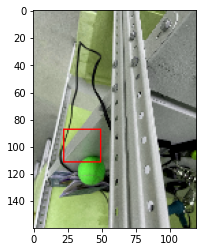

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[39, 36, 54, 47]


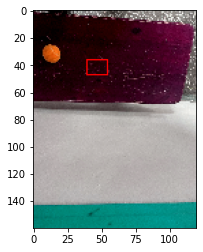

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[64, 80, 99, 108]


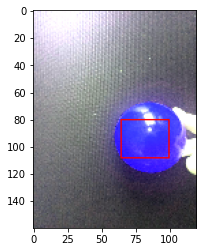

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[44, 53, 82, 96]


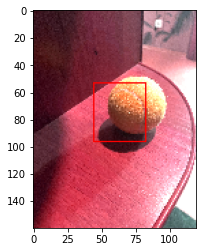

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24, 67, 68, 93]


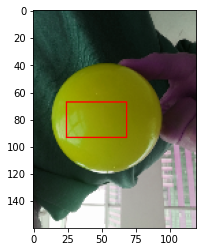

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[38, 53, 81, 99]


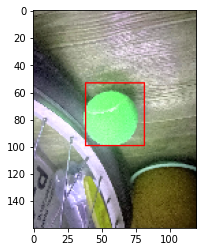

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[49, 64, 87, 97]


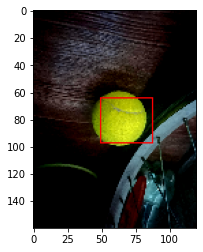

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23, 48, 63, 79]


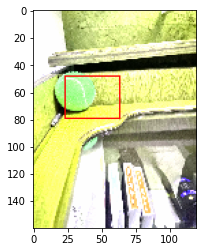

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[48, 70, 78, 103]


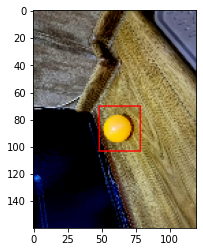

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[62, 64, 86, 76]


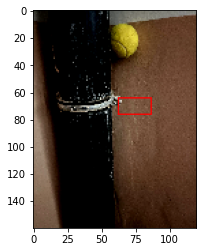

In [213]:
predictions = model.predict(test_imgs)
for i in range(len(test_imgs[:10])):
    roi = predictions[i]
    roi = list(map(int,[roi[0]*image_shape[1],roi[1]*image_shape[0],roi[2]*image_shape[1],roi[3]*image_shape[0]]))
    img = test_imgs[i].copy()
    cv2.rectangle(img,(roi[0],roi[1]),(roi[2],roi[3]),(255,0,0), 1)
    print(roi)
    plt.imshow(img)
    plt.show()

In [214]:
model.save('ball_roi_model.h5')